In [35]:
!apt-get update
!apt-get install -y graphviz graphviz-dev pkg-config
!pip install pygraphviz coloraide
!pip install visual-automata

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [36]:
from visual_automata.fa.nfa import NFA as NondeterministicFiniteAutomaton
import string

def create_noun_morphology_nfa():
    letters = set(string.ascii_lowercase)

    sibilants = {'s', 'x', 'z'}
    other_letters = letters - sibilants - {'c', 'y'}
    nfa = NondeterministicFiniteAutomaton(
        states={'q0', 'qc', 'qs', 'q_sibilant', 'qy', 'q_i_to_y', 'q_es', 'q_ies', 'qF'},
        input_symbols=letters,
        transitions={
            'q0': {
                's': {'qF', 'qs'},
                'c': {'qc'},
                'x': {'q_sibilant'},
                'z': {'q_sibilant'},
                'y': {'qy'},
                'i': {'q0', 'q_i_to_y'},
                **{letter: {'q0'} for letter in other_letters}
            },
            'qc': {
                'h': {'q_sibilant'},
                's': {'qF'},       
                **{letter: {'q0'} for letter in letters - {'h', 's'}}
            },
            'qs': {
                'h': {'q_sibilant'}, 
                'e': {'q_es'},      
                **{letter: {'q0'} for letter in letters - {'h', 'e'}}
            },
            'q_sibilant': {
                'e': {'q_es'}
            },
            'qy': {
                'i':{'q_i_to_y'},
                **{letter: {'q0'} for letter in letters - {'i'}}
            },
            'q_i_to_y': {
                'e': {'q_ies'}
            },
            'q_es': {
                's': {'qF'}
            },
            'q_ies': {
                's': {'qF'}
            },
            'qF': {}
        },
        initial_state='q0',
        final_states={'q0', 'qc', 'qs', 'q_sibilant', 'qy', 'qF'}
    )
    return nfa

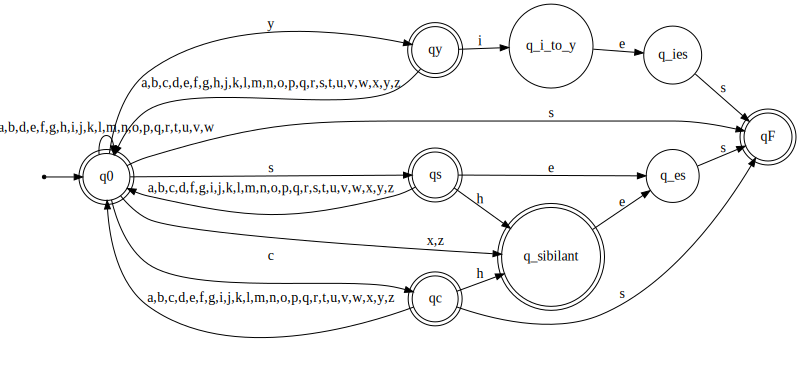

In [37]:
nfa=create_noun_morphology_nfa()
nfa.show_diagram()

In [38]:
import pandas as pd

rows = []
for state, trans in nfa.transitions.items():
    for symbol, next_states in trans.items():
        rows.append([state, symbol, ", ".join(next_states)])

df = pd.DataFrame(rows, columns=["State", "Input", "Next States"])
print(df.to_string(index=False))


     State Input Next States
        q0     s      qF, qs
        q0     c          qc
        q0     x  q_sibilant
        q0     z  q_sibilant
        q0     y          qy
        q0     i          q0
        q0     k          q0
        q0     o          q0
        q0     m          q0
        q0     b          q0
        q0     v          q0
        q0     u          q0
        q0     t          q0
        q0     j          q0
        q0     q          q0
        q0     r          q0
        q0     h          q0
        q0     w          q0
        q0     f          q0
        q0     a          q0
        q0     g          q0
        q0     e          q0
        q0     p          q0
        q0     n          q0
        q0     l          q0
        q0     d          q0
        qc     h  q_sibilant
        qc     s          qF
        qc     k          q0
        qc     o          q0
        qc     m          q0
        qc     b          q0
        qc     v          q0
        qc    

In [39]:
def transduce(nfa, word):
    if not isinstance(word, str) or not word.isalpha():
        return "Invalid Word"

    word = word.lower()

    if not nfa.accepts_input(word):
        return "Invalid Word"

    # Rule 1: E-insertion (e.g., foxes -> fox, watches -> watch)
    # Checks for roots ending in s, z, x, ch, sh followed by 'es'.
    if len(word) > 2 and word.endswith('es'):
        if word.endswith('ches') or word.endswith('shes'):
            root = word[:-2]
            return f"{root}+N+PL"
        if word[-3] in 'sxz':
            root = word[:-2]
            return f"{root}+N+PL"

    # Rule 2: Y-replacement (e.g., cities -> city)
    # Checks for roots ending in 'y' where 'y' is replaced by 'ies'.
    if len(word) > 3 and word.endswith('ies'):
        # Check if the character before 'ies' is a consonant (a simplification)
        consonants = "bcdfghjklmnpqrstvwxyz"
        if word[-4] in consonants:
            root = word[:-3] + 'y'
            return f"{root}+N+PL"

    # Rule 3: S-addition (e.g., bags -> bag)
    # A word ending in 's' is only a plural if it's NOT a sibilant root
    # that would require 'es' for its plural form.
    if len(word) > 1 and word.endswith('s'):
        # Excludes words ending in 'ss' (class), 'us' (bus), etc. which are singular.\
        if not (word.endswith('ss') or word.endswith('us')):
             # Check if it's not a sibilant that should have had an 'es'
            if not (word[-2] in 'xz' or word.endswith('chs') or word.endswith('shs')):
                root = word[:-1]
                return f"{root}+N+PL"

    return f"{word}+N+SG"

In [40]:
from google.colab import files
uploaded = files.upload()

Saving brown_nouns.txt to brown_nouns (2).txt


In [1]:
with open("brown_nouns.txt", "r") as f:
    valid_words = set(line.strip() for line in f if line.strip())
for word in valid_words:
  analysis = transduce(nfa, word)
  if "Invalid Word"  in analysis:
     print(f"{word} -> {analysis}")

NameError: name 'transduce' is not defined